In [1]:
import numpy as np
from qiskit import *
import random
import time
from numpy import log as ln
import warnings
warnings.filterwarnings('ignore', module = 'qiskit')
# warnings.filterwarnings(action='once')

from qiskit.algorithms.optimizers import ADAM, AQGD, COBYLA, SPSA, TNC, CG, L_BFGS_B, GSLS, NELDER_MEAD, NFT, P_BFGS, POWELL, SLSQP
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI
from qiskit.opflow import CircuitStateFn, StateFn, I, X, Y, Z, H, CX, Zero, One, OperatorBase

from itertools import combinations as cm

In [2]:
# Generate Primes as an array
primes = [2,3,5]#,7,11,17,19,,31,37]
primes = primes[::-1]

combinations = list(cm(range(len(primes)), 2))

In [3]:
# Generate Quantum Circuit single layer
def generate_circuit(params, assigned=True):
    cir = QuantumCircuit(len(primes))
    layers = int(len(params)/(4 * len(primes)))
    thetas = [qiskit.circuit.Parameter(str(i)) for i in range(len(primes) * 4 *layers)]
    thetas_reshape = np.reshape(np.asarray(thetas),(layers, len(primes) * 4))
    params = np.reshape(np.asarray(params),(layers, len(primes) * 4))
#     cir.x(0)
#     cir.x(1)
#     cir.x(2)
#     cir.x(3)
#     cir.x(4)
#     cir.x(5)
#     cir.x(6)
#     cir.h(range(len(primes)))
    for m in range(layers):
        l = len(params[m])
        g = thetas_reshape[m][0:int(l/4)]
        b = thetas_reshape[m][int(l/4): int(2*l/4)]
        a = thetas_reshape[m][int(2*l/4): int(3*l/4)]
        t = thetas_reshape[m][int(3*l/4):l]

        for i in range(len(primes)):
            cir.ry(g[i], i)
        for j in range(len(primes)):
            if j != 0:
                cir.crz(b[j], j-1, j)
            else:
                cir.crz(b[j], len(primes)-1, j)
        for k in range(len(primes)):
            cir.ry(a[k], k)
        for o in range(len(primes)):
            cir.rx(t[o], o)
    if assigned == True:
        thetas_reshape = thetas_reshape.flatten()
        params = params.flatten()
        p_dict = {thetas_reshape[i] : params[i] for i in range(len(thetas))}
        cir.assign_parameters(p_dict, inplace=True)
    cir.measure_all()
    
    return cir, thetas

In [4]:
def generate_ZZcircuit(params, primes, assigned=True):
    cir = QuantumCircuit(len(primes))
    layers = int(len(params)/((2 * len(primes)) + len(combinations)))
    thetas = [qiskit.circuit.Parameter(str(i)) for i in range(layers * ((2 * len(primes)) + len(combinations)))]
    thetas_reshape = np.reshape(np.asarray(thetas),(layers, ((2 * len(primes)) + len(combinations))))
    params = np.reshape(np.asarray(params),(layers, ((2 * len(primes)) + len(combinations))))
    combs = list(cm(range(len(primes)), 2))
#     cir.h(range(len(primes)))
    
    for m in range(layers):
        l = len(params[m])
        g = thetas_reshape[m][0: len(primes)]
        a = thetas_reshape[m][len(primes): (len(primes) + len(combs))]
        b = thetas_reshape[m][(len(primes) + len(combs)) : l]
        
        for h in range(len(primes)):
            cir.rz(g[h], h)
        
        i = 0
        for j, k in combs:
            cir.rzz(a[i], j, k)
            i += 1
        for l in range(len(primes)):
            cir.rx(b[l], l)
            
    if assigned == True:
        thetas_reshape = thetas_reshape.flatten()
        params = params.flatten()
        p_dict = {thetas_reshape[i] : params[i] for i in range(len(thetas))}
        cir.assign_parameters(p_dict, inplace=True)
    cir.measure_all()
    
    return cir, thetas

[2.0232348834067215, 0.6851582420138922, 2.9828481946722682, 0.42703112081673533, 0.023397384983749124, 1.7934989292967802, 2.1365870152260285, 0.7018635687052959, 2.1494774168007225]


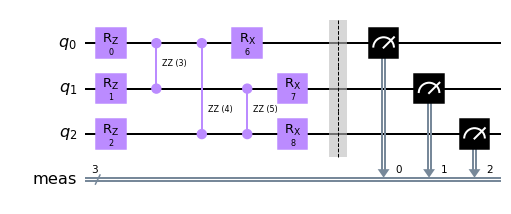

In [5]:
hyperparam = [random.uniform(0,np.pi) for _ in range(1 * ((2 * len(primes)) + len(combinations)))]
print(hyperparam)
cir, free_params = generate_ZZcircuit(hyperparam, primes, assigned=False)
cir.draw('mpl')

In [6]:
def obj_function(counts, n, penalty):
    max_c = 0
    max_bit = ""
    for c in counts:
        if counts[c] >= max_c:
            max_c =  counts[c]
            max_bit = c
    comp_primes = 1
    for i in range(len(max_bit)):
        comp_primes *= primes[i]**int(max_bit[i])
    p = 0
    if penalty == 1:
        if comp_primes > n:
            p += comp_primes 
#         return (n - comp_primes)**2
#     print(comp_primes, n-comp_primes, p)
    return (n - comp_primes) + p

In [7]:
def f(theta):
    n = 30
    qc, free_params = generate_ZZcircuit(theta, primes)
    back = Aer.get_backend('aer_simulator')
    back.set_options(device='GPU')
    job_sim = execute(qc, backend = back, shots = 2048).result()
    counts = job_sim.get_counts(qc)
        
    return obj_function(counts, n, 1)

def gen_f(n):
    
    def f(theta):
        qc, free_params = generate_ZZcircuit(theta, primes)
        back = Aer.get_backend('aer_simulator')
        back.set_options(device='GPU')
        job_sim = execute(qc, backend = back, shots = 2048).result()
        counts = job_sim.get_counts(qc)
        
        return obj_function(counts, n, 1)

    return f

In [8]:
def X_generator(primes, identity):
    #Generate X value for hamiltonian
    constant = 0

    for i in range(len(primes)):
        #Build Constant value iteratively
        constant += ln(primes[i])
        
        if i == 0:
            z_value = Z
        else:
            z_value = I
        #Build rest of X
        for j in range(1, len(primes)):
            if j == i:
                z_value = z_value ^ Z
            else:
                z_value = z_value ^ I
        if i == 0:
            x = -ln(primes[i]) * z_value
        else:
            x -= ln(primes[i]) * z_value
    #Combine Both to form X
    x += constant * identity
    
    return x

def hamiltonian(n, primes):
    #Generate Hamitonian according to number of primes
    identity = I
    
    for i in range(len(primes) - 1):
        identity = identity ^ I
        
    x = X_generator(primes, identity)
    
    lnn = float(ln(n))
    
    h = ((lnn**2) * identity) - (lnn * x) + (1 / 4 * (x ** 2))
    
    return h

In [9]:
h_value = hamiltonian(5, primes)
print(h_value.to_matrix())

[[ 2.59029039e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  8.39588705e-01+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  2.60942818e-01+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   3.32411501e-02+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j -4.44089210e-16+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  4.80453014e-01+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j

In [10]:
 def _convert_to_gradient_function(gradient_object, layers, n):

        def gradient_function(current_point):

            cir, free_params = generate_ZZcircuit(current_point, primes, assigned=False)
            cir.remove_final_measurements()
            c = hamiltonian(n, primes)
            op = ~StateFn(c) @ CircuitStateFn(primitive=cir, coeff=1.)
            grad_object = gradient_object.convert(operator=op, params=free_params)
            value_dict = {free_params[i]: current_point[i] for i in range(len(free_params))}
            x = grad_object.assign_parameters(value_dict).eval()
#             print(x)
#             analytical_gradients = np.array(x)# Change this part
            return np.real(x)
        
        return gradient_function

In [11]:
# from scipy import optimize as op
# optimizer =  AQGD(maxiter=1000)
# layers = 1
# func = f
# grad = "param_shift"
# gradient_function =Gradient(grad_method=grad)
# g_f = _convert_to_gradient_function(gradient_function, layers, 30)
# theta = [random.uniform(0, 2 * np.pi) for _ in range(layers * ((2 * len(primes)) + len(combinations)))]
# # res_sample = op.minimize(func, x0 = theta, method='COBYLA', options={'maxiter':1000})
# # theta = res_sample['x']
# # loss = res_sample['fun']
# theta, loss, _ = optimizer.optimize(
#             num_vars=len(theta),
#             objective_function=func,
#             initial_point=theta,
#             gradient_function=g_f
#             )

In [12]:
# print(loss, theta)

In [13]:
# theta = res_sample.x
# theta =[2.763785562212966, 1.322415858639598, 1.3308235519001288, 2.4978133840322934, 4.2866331530605715, 1.1067569137053306, 0, 0]
# qc, free_params = generate_ZZcircuit(theta, primes)
# counts = execute(qc, backend = Aer.get_backend('aer_simulator'), shots = 2048).result().get_counts()

In [14]:
# from qiskit.visualization import plot_histogram
# plot_histogram(counts, figsize=(30, 20))

In [15]:
# import math
# n = 30
# r = obj_function(counts, n, 0)
# print(r)
# og_bits = int(math.ceil(math.log2(n)))
# compressed_bits = (len(primes)) + int(math.ceil(math.log2(r)))
# print("Original bit = ", og_bits, ' Compressed_bits = ', compressed_bits, ' compression raito =', compressed_bits/ og_bits)

In [16]:
def run(optimizer, layers, func, gradient_function, n):
    g_f = _convert_to_gradient_function(gradient_function, layers, n)
    theta = [random.uniform(0, 2 * np.pi) for _ in range(layers * ((2 * len(primes)) + len(combinations)))]
    theta, loss, _ = optimizer.optimize(
                num_vars=len(theta),
                objective_function=func,
                initial_point=theta,
                gradient_function=g_f
                )
    return loss

gradient_types = ['', 'param_shift', 'lin_comb', 'fin_diff']
op_types = [AQGD(maxiter = 100), COBYLA(maxiter = 100), TNC(maxiter = 100), CG(maxiter = 100), GSLS(maxiter = 100), NELDER_MEAD(maxiter = 100)]#, NFT(maxiter = 500)]#, P_BFGS(maxfun = 500), POWELL(maxiter = 500), SLSQP(maxiter = 500)]
loss_list = []


for i in [5, 10]:
    print("Current n = ", i)
    fun = gen_f(i)
    n_list = []
    for j in range(1, 2):
        print("Current layer = ", j)
        layer_list = []
        for k in range(len(op_types)):
            print("Current opt = ", k)
            opt = op_types[k]
            grad_list = []
            for g in range(len(gradient_types)):
                print("Current Gradient = ", gradient_types[g] )
                if g == 0:
                    grad = Gradient()
                else:
                    grad = Gradient(grad_method=gradient_types[g])
                samples = []
                for _ in range(10):
                    start = time.perf_counter()
                    loss = run(opt,  j, fun, grad, i)
                    end = time.perf_counter()
                    samples.append((loss, end - start))
                grad_list.append(samples)
            layer_list.append(grad_list)
        n_list.append(layer_list)
    loss_list.append(n_list)

Current n =  5
Current layer =  1
Current opt =  0
Current Gradient =  
Current Gradient =  param_shift
Current Gradient =  lin_comb
Current Gradient =  fin_diff
Current opt =  1
Current Gradient =  
Current Gradient =  param_shift
Current Gradient =  lin_comb
Current Gradient =  fin_diff
Current opt =  2
Current Gradient =  
Current Gradient =  param_shift
Current Gradient =  lin_comb
Current Gradient =  fin_diff
Current opt =  3
Current Gradient =  
Current Gradient =  param_shift
Current Gradient =  lin_comb
Current Gradient =  fin_diff
Current opt =  4
Current Gradient =  
Current Gradient =  param_shift
Current Gradient =  lin_comb
Current Gradient =  fin_diff
Current opt =  5
Current Gradient =  
Current Gradient =  param_shift
Current Gradient =  lin_comb
Current Gradient =  fin_diff
Current n =  10
Current layer =  1
Current opt =  0
Current Gradient =  
Current Gradient =  param_shift
Current Gradient =  lin_comb
Current Gradient =  fin_diff
Current opt =  1
Current Gradient =

In [17]:
print(loss_list)

[[[[[(5, 26.43226627999684), (0, 17.191282504005358), (5, 17.227236587990774), (0, 20.41838789799658), (2, 17.298664109010133), (0, 31.192857465008274), (5, 21.89796524400299), (0, 26.669267687000684), (0, 17.196972591991653), (5, 30.04267384999548)], [(5, 23.61901429099089), (5, 23.575470580995898), (5, 20.407243234993075), (5, 17.22505086599267), (0, 17.318910036003217), (0, 20.29346050300228), (2, 20.360444229998393), (2, 20.362198899005307), (0, 20.33456600100908), (2, 17.247264816993265)], [(0, 17.235772761996486), (0, 13.551417911003227), (0, 13.523722921003355), (0, 20.94334787801199), (5, 13.558253276991309), (2, 13.56598381799995), (5, 13.62383639300242), (0, 13.549963088007644), (0, 16.032719748996897), (5, 21.007764519992634)], [(0, 17.360547418997157), (2, 15.922300357997301), (5, 23.226974919001805), (5, 15.941857685000286), (5, 17.420285896994756), (0, 16.051068278000457), (2, 18.877765039011138), (0, 17.424549018993275), (5, 16.025323359004688), (5, 15.928283957997337)]]

In [18]:
ll = np.asarray(loss_list)
ll.shape

(2, 1, 6, 4, 10, 2)

In [19]:
np.save("newHamTest510_optimizercomparison", ll,)